In [2]:
MODEL = 'gpt-4o'

导入必要的模块，包括os用于路径操作，cv2用于视频处理，base64用于编码帧，以及moviepy.editor用于处理音频。函数extract_frames_and_audio，用于提取视频帧和音频。参数video_file为视频文件路径，interval为每提取一帧所间隔的秒数。使用OpenCV遍历视频并提取指定间隔的帧。将每个帧编码为Base64格式并存储在列表中。使用MoviePy从视频中提取音频并保存为MP3文件。

In [3]:
# 导入所需的库
import os
import cv2 # 视频处理
import base64 # 编码帧
from moviepy.editor import VideoFileClip # 音频处理

VIDEO_FILE = "Good_Driver.mp4"

def extract_frames_and_audio(video_file, interval=2):
    encoded_frames = []
    file_name, _ = os.path.splitext(video_file)

    video_capture = cv2.VideoCapture(video_file)
    total_frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
    frames_interval = int(frame_rate * interval)
    current_frame = 0

    # 循环遍历视频并以指定的采样率提取帧
    while current_frame < total_frame_count - 1:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        success, frame = video_capture.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        encoded_frames.append(base64.b64encode(buffer).decode("utf-8"))
        current_frame += frames_interval
    video_capture.release()

    # 从视频中提取音频
    audio_output = f"{file_name}.mp3"
    video_clip = VideoFileClip(video_file)
    video_clip.audio.write_audiofile(audio_output, bitrate="32k")
    video_clip.audio.close()
    video_clip.close()

    print(f"提取了 {len(encoded_frames)} 帧")
    print(f"音频提取到 {audio_output}")
    return encoded_frames, audio_output

# 每2秒提取1帧（采样率）
encoded_frames, audio_output = extract_frames_and_audio(VIDEO_FILE, interval=2)

MoviePy - Writing audio in Good_Driver.mp3


MoviePy - Done.
提取了 17 帧
音频提取到 Good_Driver.mp3


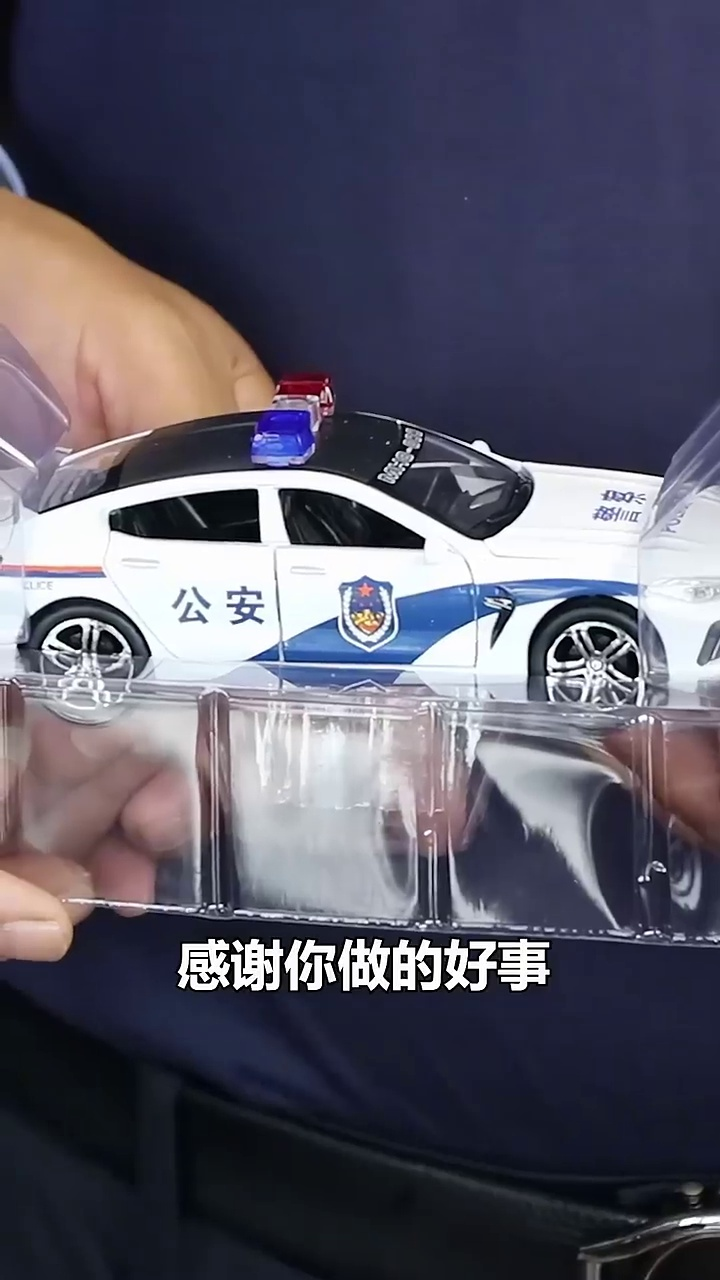

In [4]:
import time
from IPython.display import Image, display, Audio

# 创建显示句柄以动态更新显示内容
display_handle = display(None, display_id=True)

# 显示提取的帧，每帧之间暂停0.025秒
for frame in encoded_frames:
    display_handle.update(Image(data=base64.b64decode(frame.encode("utf-8")), width=600))
    time.sleep(0.025)

# 显示提取的音频
Audio(audio_output)

In [5]:
# 导入OpenAI模块
from openai import OpenAI 
# 创建OpenAI客户端
client = OpenAI()

# 转录音频
transcription = client.audio.transcriptions.create(
    model="whisper-1",  # 使用的模型是whisper-1
    file=open(audio_output, "rb"),  # 打开音频文件
)

# 音频转录结果
print("转录: ", transcription.text + "\n\n")

转录:  像开启的云 叹声骤落 今生再开 化成沙 嘿 还活着的你 只在你眼睛 你不放弃你 你不放弃你




In [6]:
# 使用GPT-4o模型生成视音频整体介绍
response = client.chat.completions.create(
    model='gpt-4o',
    messages=[
    {"role": "system", "content":"""You are generating a video summary. Create a summary of the provided video and its transcript. Respond in Markdown"""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url", 
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, encoded_frames),
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

### Video Summary

The video appears to document a sequence of events involving a road hazard and the subsequent actions taken by a driver to ensure safety. Here is a summary based on the provided frames:

1. **Initial Scene**: A blue truck is seen driving on a road with a noticeable pothole or road damage.
2. **Hazard Identification**: The text on the screen indicates that the road damage poses a safety risk to oncoming vehicles.
3. **Immediate Response**: A red car approaches the damaged area, and a larger truck, driven by Su Jinyang, stops nearby.
4. **Safety Measures**: Su Jinyang exits his truck, activates the hazard lights, and proceeds to address the situation.
5. **Gathering Equipment**: Su Jinyang runs to the roadside to retrieve a barricade and traffic cones.
6. **Setting Up Warning Signs**: He places the cones around the damaged area to warn other drivers.
7. **Ensuring Safety**: Su Jinyang confirms the setup and reports the hazard before leaving the scene.
8. **Traffic Mana